In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn, Tensor, optim

import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simple neural network and training
In this final example, we'll take a <mark>simple classification problem, and train a neural network to solve it.</mark>

First we need some data:

### Data generation

In [3]:
n = 200
r = np.linspace(0.1,5, n)+np.random.normal(scale=0.3, size=n)
t = np.linspace(-np.pi, np.pi, n)
x0 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.ones_like(t))))
t = np.linspace(0, 2*np.pi, n)
x1 = np.array(list(zip(r*np.cos(t), r*np.sin(t), np.zeros_like(t))))

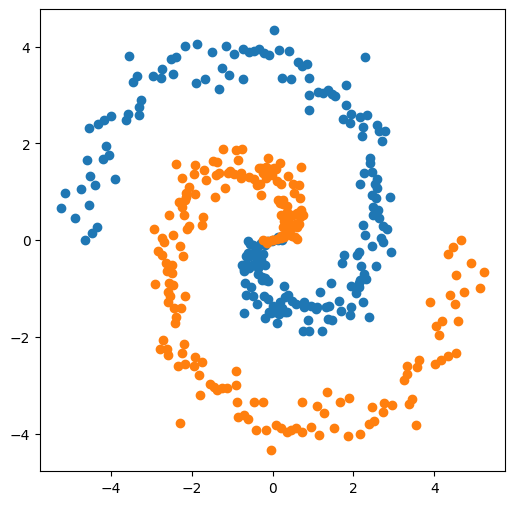

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(x0[:,0], x0[:,1])
plt.scatter(x1[:,0], x1[:,1]);

So we have points of two classes, indicated by their colour, which exist in 2D, and follow an obvious pattern, which the DNN should be able learn.

In [5]:
data = np.vstack((x0, x1))
np.random.shuffle(data)
x = Tensor(data[:,0:2])
y = Tensor(data[:,2:3])

x[:10], y[:10]

(tensor([[ 2.1725, -4.0025],
         [ 0.2899,  0.4029],
         [ 0.2118,  1.1537],
         [-0.3821,  1.1390],
         [ 0.1901,  1.5982],
         [-1.5104,  3.8826],
         [ 0.5651,  0.0718],
         [-1.6782,  3.3390],
         [ 0.7252, -3.9508],
         [ 0.4940,  1.1600]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.]]))

<mark>x are our inputs for the network - the position of the points in 2D space</mark>

<mark>y are the target for the network - the classes for the corresponding points</mark>

### DNN
Now we need a suitable DNN for fit to the data

In [6]:
class DNN(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.layers = nn.Sequential(*[self.get_layer(sizes[i], sizes[i+1]) for i in range(len(sizes)-2)])
        self.out_layer = self.get_layer(sizes[-2], sizes[-1], out_layer=True)

    @staticmethod
    def get_layer(nin, nout, out_layer=False):
        lin = nn.Linear(nin, nout)
        if out_layer:
            nn.init.xavier_normal_(lin.weight)
            act = nn.Sigmoid()
        else:
            nn.init.kaiming_normal_(lin.weight, nonlinearity='relu')
            act = nn.ReLU()
        nn.init.zeros_(lin.bias)
        
        return nn.Sequential(lin, act)
    
    def forward(self, x):
        x = self.layers(x)
        return self.out_layer(x)

In [7]:
dnn = DNN([2,10,10,1])
dnn

DNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (out_layer): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

### Loss function
For this, we can just use binary cross entropy

In [8]:
loss_fn = nn.BCELoss()

### Optimiser
This time, we'll use ([paper](https://arxiv.org/abs/1412.6980), [blog](https://ruder.io/optimizing-gradient-descent/index.html#adam)), which is a more advanced optimiser 

In [9]:
opt = optim.Adam(dnn.parameters(), lr=1e-2)

## Training loop
This won't be a fully fleshed-out training loop, and <mark>there will definitely be things missing that we'd want for actual work use; this is just to demonstrate the "bare minimum" required.</mark>

In [10]:
normed_x = (x-x.mean(0))/x.std(0)  # Normalise the inputs per feature

In [11]:
def train(dnn, *, inputs, targets, batch_size, loss_fn, opt, nepochs):
    for epoch in range(1,nepochs+1):
        idxs = torch.randperm(len(data)) # shuffle indices of the data (rather than the data itself)
        epoch_losses = []
        
        for batch in range(0, len(data)-batch_size, batch_size):  # Loop through minibatches of data
            batch_idxs = idxs[batch : batch+batch_size]
            pred = dnn(inputs[batch_idxs])  # Forwards pass
            loss = loss_fn(pred, targets[batch_idxs])
            epoch_losses.append(loss.item())
            opt.zero_grad()  # Make sure the grads are zero
            loss.backward()  # Backwards pass and update
            opt.step()
        
        print(f'Epoch {epoch}: loss = {np.mean(epoch_losses)}')

In [12]:
train(dnn, inputs=normed_x, targets=y, batch_size=32, loss_fn=loss_fn, opt=opt, nepochs=25)

Epoch 1: loss = 0.8082289844751358
Epoch 2: loss = 0.6416794459025065
Epoch 3: loss = 0.5973396450281143
Epoch 4: loss = 0.561501587430636
Epoch 5: loss = 0.5373234276970228
Epoch 6: loss = 0.5129778881867727
Epoch 7: loss = 0.47871266553799313
Epoch 8: loss = 0.45037438720464706
Epoch 9: loss = 0.4143531769514084
Epoch 10: loss = 0.377385675907135
Epoch 11: loss = 0.33444275707006454
Epoch 12: loss = 0.29054051886002225
Epoch 13: loss = 0.2490923528869947
Epoch 14: loss = 0.20436915010213852
Epoch 15: loss = 0.16746512427926064
Epoch 16: loss = 0.1334572390963634
Epoch 17: loss = 0.11156554395953815
Epoch 18: loss = 0.0985984733949105
Epoch 19: loss = 0.08761896844953299
Epoch 20: loss = 0.07733596271524827
Epoch 21: loss = 0.06936672391990821
Epoch 22: loss = 0.06627288196856777
Epoch 23: loss = 0.05967314696560303
Epoch 24: loss = 0.05791391804814339
Epoch 25: loss = 0.05425730006148418


So, we can see that the loss of our network decreased. Let's check its performance

In [13]:
with torch.inference_mode():
    preds = dnn(normed_x)

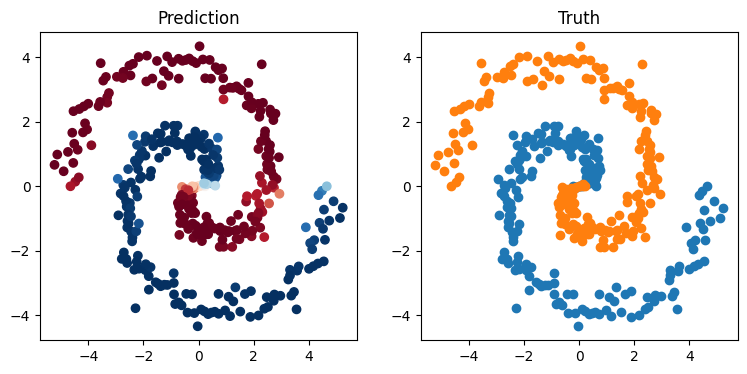

In [14]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
axs[0].scatter(x[:,0], x[:,1], c=preds.squeeze(), cmap='RdBu_r')
axs[0].set_title('Prediction')
mask = y.squeeze() == 1
axs[1].scatter(x[~mask][:,0], x[~mask][:,1])
axs[1].scatter(x[mask][:,0], x[mask][:,1])
axs[1].set_title('Truth');

In [15]:
res = 50
a, b, pred_map = [], [], []

with torch.inference_mode():
    for i in np.linspace(x[:,0].min(), x[:,0].max(), res):
        x0 = i*np.ones((res,))
        x1 = np.linspace(x[:,1].min(), x[:,1].max(), res)
        pred_map += list(dnn((Tensor(list(zip(x0,x1)))-x.mean(0))/x.std(0)).squeeze())
        a += list(x0)
        b += list(x1)

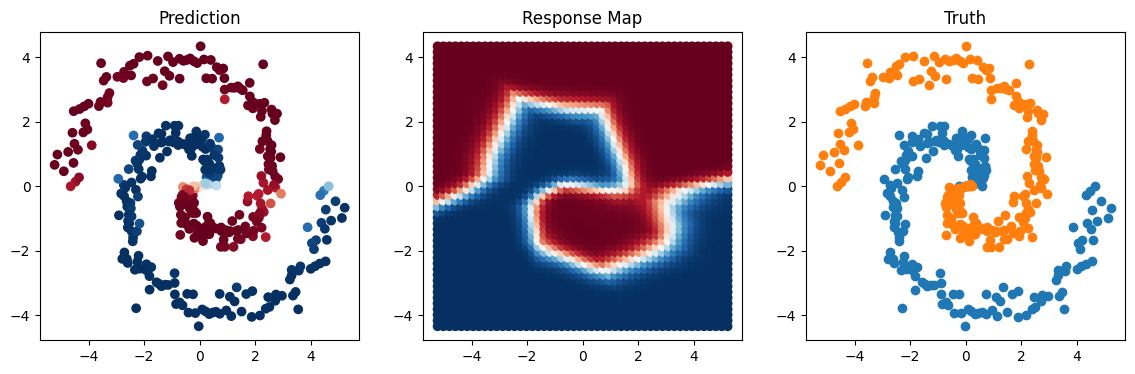

In [16]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
axs[0].scatter(x[:,0], x[:,1], c=preds.squeeze(), cmap='RdBu_r')
axs[0].set_title('Prediction')
axs[1].scatter(a, b, c=pred_map, cmap='RdBu_r')
axs[1].set_title('Response Map')
mask = y.squeeze() == 1
axs[2].scatter(x[~mask][:,0], x[~mask][:,1])
axs[2].scatter(x[mask][:,0], x[mask][:,1])
axs[2].set_title('Truth');

Note the <mark>piece-wise linear response of the network, and it's lack of extrapolation capabilities</mark>